In [1]:
import time
from datetime import date
import pandas as pd
import os
import glob
import pycytominer
import sys
import CBE_utils as CBE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.spatial.distance import correlation
import re
import gc

In [2]:
import importlib
importlib.reload(CBE)

<module 'CBE_utils' from '/home/schmiedc/FMP_Docs/Projects/ECBL_Project/QualityControl_analysis_revision/notebooks_revision/CBE_utils.py'>

In [3]:
input_path = "/home/schmiedc/FMP_Docs/Projects/ECBL_Project/QualityControl_analysis_revision/output/"
output_path = "/home/schmiedc/FMP_Docs/Projects/ECBL_Project/QualityControl_analysis_revision/results/"

annotation_dir = "/home/schmiedc/FMP_Docs/Projects/ECBL_Project/QualityControl_analysis_revision/annotation/"

In [4]:
# get folder list 
# load for each site the normalized files
# reduce the features selecting the correct feature list
folders = [name for name in os.listdir(input_path) if os.path.isdir(os.path.join(input_path, name))]

In [5]:
pattern = "[A-Z][0-9][0-9][0-9][0-9]_R[1-4]_mad_robustize_reduced-corr.csv"

FMP_Data = []
IMTM_Data = []
MEDINA_Data = []
USC_Data = []

for folder in folders:

    site_specific_path = os.path.join(input_path, folder)

    # load normalized data
    file_list = glob.glob(site_specific_path + os.sep + '*' + os.sep + pattern, recursive=True)

    for file in file_list:

        filename = os.path.basename(file)
    
        try:
        
            Data_Temp = pd.read_csv(file)
            row_count = Data_Temp.shape[0]
        
            print(f"File: {filename} has {row_count} rows")
        
            if folder == 'FMP':
                
                FMP_Data.append(Data_Temp)

            elif folder == 'IMTM':

                IMTM_Data.append(Data_Temp)

            elif folder == 'MEDINA':

                MEDINA_Data.append(Data_Temp)

            elif folder == 'USC':

                USC_Data.append(Data_Temp)
            
        except Exception as e:
        
            print(f"Error reading file {filename}: {e}")
        
        


File: C1231_R1_mad_robustize_reduced-corr.csv has 384 rows
File: C1269_R2_mad_robustize_reduced-corr.csv has 384 rows
File: C1270_R3_mad_robustize_reduced-corr.csv has 384 rows
File: C1245_R4_mad_robustize_reduced-corr.csv has 384 rows
File: C1234_R3_mad_robustize_reduced-corr.csv has 384 rows
File: C1239_R1_mad_robustize_reduced-corr.csv has 384 rows
File: C1241_R1_mad_robustize_reduced-corr.csv has 384 rows
File: C1232_R3_mad_robustize_reduced-corr.csv has 384 rows
File: C1264_R4_mad_robustize_reduced-corr.csv has 384 rows
File: C1272_R3_mad_robustize_reduced-corr.csv has 384 rows
File: C1247_R4_mad_robustize_reduced-corr.csv has 384 rows
File: C1254_R3_mad_robustize_reduced-corr.csv has 384 rows
File: C1233_R3_mad_robustize_reduced-corr.csv has 384 rows
File: C1269_R3_mad_robustize_reduced-corr.csv has 384 rows
File: C1237_R1_mad_robustize_reduced-corr.csv has 384 rows
File: C1250_R3_mad_robustize_reduced-corr.csv has 384 rows
File: C1233_R4_mad_robustize_reduced-corr.csv has 383 ro

In [6]:
### concat all files together
FMP_Data_aggregated = pd.concat(FMP_Data)
FMP_Data_aggregated = FMP_Data_aggregated.reset_index(drop = True)
print("Aggregated Data has shape ", FMP_Data_aggregated.shape)

Aggregated Data has shape  (31308, 440)


In [7]:
IMTM_Data_aggregated = pd.concat(IMTM_Data)
IMTM_Data_aggregated = IMTM_Data_aggregated.reset_index(drop = True)
print("Aggregated Data has shape ", IMTM_Data_aggregated.shape)

Aggregated Data has shape  (33407, 703)


In [8]:
MEDINA_Data_aggregated = pd.concat(MEDINA_Data)
MEDINA_Data_aggregated = MEDINA_Data_aggregated.reset_index(drop = True)
print("Aggregated Data has shape ", MEDINA_Data_aggregated.shape)

Aggregated Data has shape  (25791, 720)


In [9]:
USC_Data_aggregated = pd.concat(USC_Data)
USC_Data_aggregated = USC_Data_aggregated.reset_index(drop = True)
print("Aggregated Data has shape ", USC_Data_aggregated.shape)

Aggregated Data has shape  (57983, 701)


In [10]:
Data_aggregated = IMTM_Data_aggregated

In [11]:
Data_aggregated.head()

,Metadata_imaging_date,Metadata_instrument,Metadata_Plate,Metadata_Well_randomized,Metadata_source,Metadata_RoughID,Metadata_Batch,Metadata_Object_Count,Metadata_staining_date,Metadata_user,...,Cyto_Texture_InfoMeas2_DNA_3_00_256,Cyto_Texture_InfoMeas2_DNA_3_02_256,Cyto_Texture_InfoMeas2_DNA_5_00_256,Cyto_Texture_InfoMeas2_DNA_5_02_256,Cyto_Texture_InfoMeas2_DNA_5_03_256,Cyto_Texture_InfoMeas2_ER_3_02_256,Cyto_Texture_InverseDifferenceMoment_DNA_10_01_256,Cyto_Texture_InverseDifferenceMoment_DNA_10_03_256,Cyto_Texture_InverseDifferenceMoment_DNA_3_02_256,Cyto_Texture_InverseDifferenceMoment_ER_10_03_256
0,2024-06-05,CV8000,C1231R1,A01,IMTM,EOS_cpd,HepG2_10uM,572,240531,Alzbeta,...,-1.030901,-2.322876,-0.281445,-1.743912,-1.410961,0.569283,0.822789,2.149978,2.024563,-0.544568
1,2024-06-05,CV8000,C1231R1,A02,IMTM,EOS_cpd,HepG2_10uM,731,240531,Alzbeta,...,-2.852438,-3.152188,-2.538763,-3.617972,-2.609936,-0.403705,2.572676,2.327850,3.053795,-0.168214
2,2024-06-05,CV8000,C1231R1,A03,IMTM,EOS_cpd,HepG2_10uM,826,240531,Alzbeta,...,-1.706946,-2.192050,-1.853035,-2.686879,-2.143730,-0.847818,2.046934,1.517311,2.693928,0.624535
3,2024-06-05,CV8000,C1231R1,A04,IMTM,EOS_cpd,HepG2_10uM,786,240531,Alzbeta,...,-1.195000,-2.745011,-1.795437,-1.651469,-1.609573,-1.835112,2.092272,2.595799,2.438444,1.791407
4,2024-06-05,CV8000,C1231R1,A05,IMTM,EOS_cpd,HepG2_10uM,745,240531,Alzbeta,...,-3.616242,-5.551893,-3.649597,-3.995337,-4.102037,-0.225135,3.422622,4.165867,4.133392,0.376211


In [12]:
# get unique Metadata_RoughID
def merge_if_eos_cpd(row):

    if row['Metadata_RoughID'] == 'EOS_cpd':

        return f"{row['Metadata_plate_name']}_{row['Metadata_Well']}"
    
    else:

        return row['Metadata_RoughID']
    

Data_aggregated['Metadata_RoughID_unique'] = Data_aggregated.apply(merge_if_eos_cpd, axis=1)

In [13]:
Data_aggregated.head()

,Metadata_imaging_date,Metadata_instrument,Metadata_Plate,Metadata_Well_randomized,Metadata_source,Metadata_RoughID,Metadata_Batch,Metadata_Object_Count,Metadata_staining_date,Metadata_user,...,Cyto_Texture_InfoMeas2_DNA_3_02_256,Cyto_Texture_InfoMeas2_DNA_5_00_256,Cyto_Texture_InfoMeas2_DNA_5_02_256,Cyto_Texture_InfoMeas2_DNA_5_03_256,Cyto_Texture_InfoMeas2_ER_3_02_256,Cyto_Texture_InverseDifferenceMoment_DNA_10_01_256,Cyto_Texture_InverseDifferenceMoment_DNA_10_03_256,Cyto_Texture_InverseDifferenceMoment_DNA_3_02_256,Cyto_Texture_InverseDifferenceMoment_ER_10_03_256,Metadata_RoughID_unique
0,2024-06-05,CV8000,C1231R1,A01,IMTM,EOS_cpd,HepG2_10uM,572,240531,Alzbeta,...,-2.322876,-0.281445,-1.743912,-1.410961,0.569283,0.822789,2.149978,2.024563,-0.544568,C1231_O02
1,2024-06-05,CV8000,C1231R1,A02,IMTM,EOS_cpd,HepG2_10uM,731,240531,Alzbeta,...,-3.152188,-2.538763,-3.617972,-2.609936,-0.403705,2.572676,2.327850,3.053795,-0.168214,C1231_K17
2,2024-06-05,CV8000,C1231R1,A03,IMTM,EOS_cpd,HepG2_10uM,826,240531,Alzbeta,...,-2.192050,-1.853035,-2.686879,-2.143730,-0.847818,2.046934,1.517311,2.693928,0.624535,C1231_I19
3,2024-06-05,CV8000,C1231R1,A04,IMTM,EOS_cpd,HepG2_10uM,786,240531,Alzbeta,...,-2.745011,-1.795437,-1.651469,-1.609573,-1.835112,2.092272,2.595799,2.438444,1.791407,C1231_B09
4,2024-06-05,CV8000,C1231R1,A05,IMTM,EOS_cpd,HepG2_10uM,745,240531,Alzbeta,...,-5.551893,-3.649597,-3.995337,-4.102037,-0.225135,3.422622,4.165867,4.133392,0.376211,C1231_N10


# Paper Version

In [14]:
len(Data_aggregated)

33407

In [15]:
# Filter for plates with four replicates

replicate_list = Data_aggregated['Metadata_plate_map_name'].unique()
replicate_dataframe = pd.DataFrame(replicate_list, columns=['Metadata_plate_map_name']) 

replicate_list_newcolumns = replicate_dataframe['Metadata_plate_map_name'].str.split('_', n=1, expand=True)
replicate_dataframe['Metadata_plate_name'] = replicate_list_newcolumns[0]
replicate_dataframe['Metadata_replicate_number'] = replicate_list_newcolumns[1]

replicate_counts = replicate_dataframe.groupby('Metadata_plate_name')['Metadata_replicate_number'].count().reset_index()

replicate_counts 

,Metadata_plate_name,Metadata_replicate_number
0,C1230,4
1,C1231,4
2,C1232,4
3,C1233,4
4,C1234,4
5,C1235,4
6,C1236,3
7,C1237,4
8,C1238,4
9,C1239,2


In [16]:
# Group by 'measurement_code' and filter groups that have exactly the specified number of replicates
filtered_replicate_dataframe= replicate_dataframe.groupby('Metadata_plate_name').filter(lambda x: len(x['Metadata_replicate_number']) == 4)
filtered_replicate_dataframe = filtered_replicate_dataframe.sort_values(by=['Metadata_plate_name'])

Data_aggregated_filtered = Data_aggregated[Data_aggregated['Metadata_plate_map_name'].isin(filtered_replicate_dataframe['Metadata_plate_map_name'])]

In [17]:
Data_aggregated_filtered.head()
print(Data_aggregated_filtered['Metadata_source'].unique())
print(Data_aggregated_filtered['Metadata_plate_name'].unique())

['IMTM']
['C1231' 'C1245' 'C1234' 'C1232' 'C1272' 'C1233' 'C1237' 'C1242' 'C1238'
 'C1230' 'C1244' 'C1235']


## Toxicity filter

Toxic conditions removed with threshold 161.0
Old shape (18431, 704)
New shape (18427, 704)


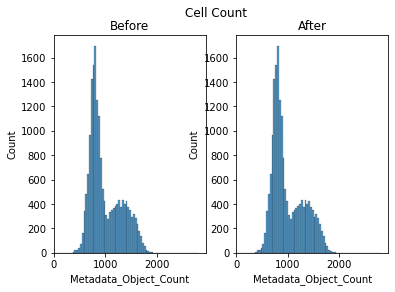

In [18]:
HepG2_Reduced_Tox, HepG2_Reduced_Tox_Cond = CBE.remove_tox(
    Data_aggregated_filtered, 
    key_col = ["Metadata_RoughID_unique", "Metadata_plate_name"], 
    SD_Threshold = 2.5,  
    plot_distribution = True)

In [19]:
len(HepG2_Reduced_Tox["Metadata_RoughID_unique"].unique())

4226

## Raw %Replication

In [20]:
HepG2_replicating, HepG2_corr_replicating_df = CBE.remove_non_reproducible(
    Data_aggregated_filtered, 
    n_samples = 10000, 
    n_replicates = 4, 
    ID_col = "Metadata_RoughID_unique", 
    description = "Data_50")

| Description   |   Percent_Replicating |
|:--------------|----------------------:|
| Data_50       |                  15.4 |
Nonreplicating conditions removed with threshold 0.14
Old shape (18431, 704)
New shape (4136, 704)


/home/schmiedc/FMP_Docs/Projects/ECBL_Project/QualityControl_analysis_revision/notebooks_revision/CBE_utils.py:391: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  corr_replicating_df = corr_replicating_df.append({'Description': description,


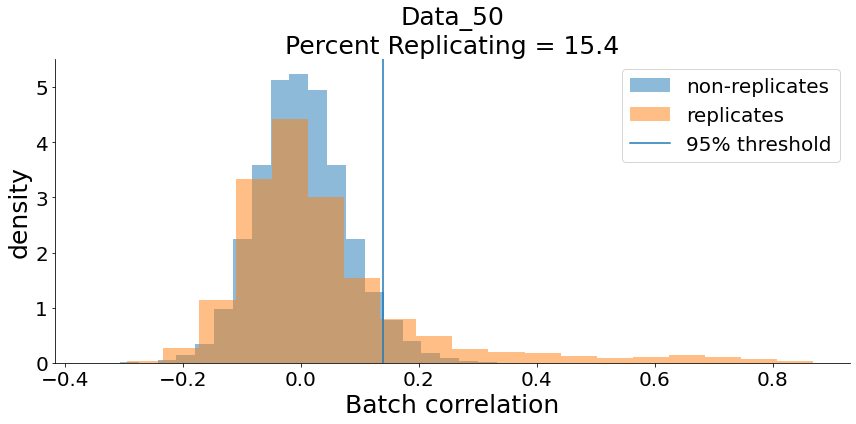

In [21]:
n_experiments = len(HepG2_corr_replicating_df)

plt.rcParams['figure.facecolor'] = 'white' # Enabling this makes the figure axes and labels visible in PyCharm Dracula theme
plt.figure(figsize=[12, n_experiments*6])

for i in range(n_experiments):
    plt.subplot(n_experiments, 1, i+1)
    plt.hist(HepG2_corr_replicating_df.loc[i,'Null_Replicating'], label='non-replicates', density=True, bins=20, alpha=0.5)
    plt.hist(HepG2_corr_replicating_df.loc[i,'Replicating'], label='replicates', density=True, bins=20, alpha=0.5)
    plt.axvline(HepG2_corr_replicating_df.loc[i,'Value_95'], label='95% threshold')
    plt.legend(fontsize=20)
    plt.title(
        f"{HepG2_corr_replicating_df.loc[i,'Description']}\n" +
        f"Percent Replicating = {HepG2_corr_replicating_df.loc[i,'Percent_Replicating']}",
        fontsize=25
    )
    plt.ylabel("density", fontsize=25)
    plt.xlabel("Batch correlation", fontsize=25)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    sns.despine()
plt.tight_layout()

plt.savefig(output_path + str(date.today()) + "_Percent_Replicating.pdf", 
            transparent=False, 
            bbox_inches='tight', 
            dpi = 600)

In [22]:
len(HepG2_replicating["Metadata_RoughID_unique"].unique())

653

## Activity filter

In [23]:
Data_aggregated_filtered["Metadata_plate_name"]

0        C1231
1        C1231
2        C1231
3        C1231
4        C1231
         ...  
18426    C1233
18427    C1233
18428    C1233
18429    C1233
18430    C1233
Name: Metadata_plate_name, Length: 18431, dtype: object

In [24]:
Data_aggregated_filtered["Metadata_RoughID_unique"]

0        C1231_O02
1        C1231_K17
2        C1231_I19
3        C1231_B09
4        C1231_N10
           ...    
18426    C1233_B15
18427    C1233_D03
18428    C1233_D20
18429         DMSO
18430    C1233_D09
Name: Metadata_RoughID_unique, Length: 18431, dtype: object

In [25]:
## gets feature vector
Features_HepG2_Norm_Reduced = CBE.get_feature_vector(Data_aggregated_filtered)

HepG2_Norm_Reduced_Median = pycytominer.consensus(
        profiles = Data_aggregated_filtered, # A file or pandas DataFrame of profile data
        replicate_columns = ["Metadata_RoughID_unique", "Metadata_plate_name", "Metadata_source"], # Metadata columns indicating which replicates to collapse, defaults to [“Metadata_Plate”, “Metadata_Well”]
        operation = "median", # (str) – The method used to form consensus profiles, defaults to “median”
        features = Features_HepG2_Norm_Reduced, # (str, list) – The features to collapse, defaults to “infer”
)

In [26]:
len(HepG2_Norm_Reduced_Median["Metadata_RoughID_unique"].unique())

4227

In [31]:
key_col = ["Metadata_RoughID_unique", "Metadata_plate_name", "Metadata_source"]

HepG2_active, HepG2_low_active = CBE.remove_low_active(HepG2_Norm_Reduced_Median, 
                                                   key_col,
                                                   3.0, 
                                                   5.0)

print("HepG2 active:", len(HepG2_active["Metadata_RoughID_unique"].unique()))
print("HepG2 low-active:", len(HepG2_low_active["Metadata_RoughID_unique"].unique()))

HepG2 active: 86
HepG2 low-active: 4142


In [32]:
HepG2_Reduced_Tox_active = Data_aggregated_filtered[
    (Data_aggregated_filtered['Metadata_RoughID_unique'].isin(HepG2_active['Metadata_RoughID_unique']))]

In [33]:
HepG2_Reduced_Tox_active["Metadata_RoughID_unique"].unique()

array(['C1231_B17', 'Nocodazole', 'C1231_L05', 'Tetrandrine', 'C1231_H02',
       'C1245_P22', 'C1245_L14', 'C1245_J11', 'C1245_G01', 'C1245_H22',
       'C1245_N03', 'C1245_C20', 'C1245_N15', 'C1245_E20', 'C1245_F04',
       'C1245_I08', 'C1245_B09', 'C1234_N02', 'C1234_M17', 'C1234_L05',
       'C1234_K19', 'C1234_F22', 'C1234_M07', 'C1234_J03', 'C1234_I05',
       'C1234_F07', 'C1234_G13', 'C1232_B03', 'C1232_M11', 'C1232_A19',
       'C1232_G04', 'C1232_G03', 'C1232_G18', 'C1232_I10', 'C1232_P22',
       'C1232_P06', 'C1232_I06', 'C1232_E07', 'C1232_P05', 'C1232_B17',
       'C1232_N04', 'C1272_B03', 'C1272_N15', 'C1272_L21', 'C1272_O20',
       'C1272_A06', 'C1272_M20', 'C1272_J13', 'C1272_C02', 'C1233_M19',
       'C1233_E20', 'C1237_E13', 'C1237_L21', 'C1237_J13', 'C1242_L20',
       'C1242_O16', 'C1242_J18', 'C1242_I08', 'C1242_G03', 'C1242_K03',
       'C1242_G06', 'C1242_G05', 'C1242_H13', 'C1242_N03', 'C1238_P19',
       'C1238_O03', 'C1238_L08', 'C1238_A11', 'C1238_K06', 'C

# Active %Replication

In [34]:
HepG2_active_replicating, HepG2_active_corr_replicating_df = CBE.remove_non_reproducible(
    HepG2_Reduced_Tox_active, 
    n_samples = 10000, 
    n_replicates = 4, 
    ID_col = "Metadata_RoughID_unique", 
    description = "Data_50")

| Description   |   Percent_Replicating |
|:--------------|----------------------:|
| Data_50       |                  98.8 |
Nonreplicating conditions removed with threshold 0.4
Old shape (528, 704)
New shape (524, 704)


/home/schmiedc/FMP_Docs/Projects/ECBL_Project/QualityControl_analysis_revision/notebooks_revision/CBE_utils.py:391: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  corr_replicating_df = corr_replicating_df.append({'Description': description,


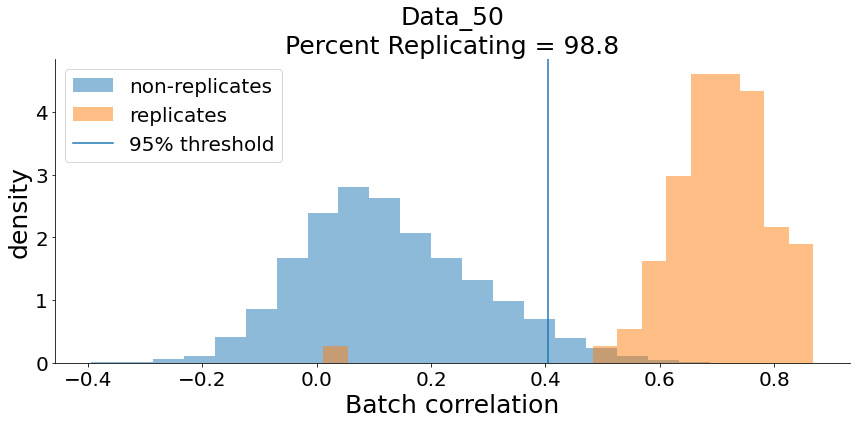

In [35]:
# plot % replicating
corr_replicating_df = HepG2_active_corr_replicating_df

n_experiments = len(corr_replicating_df)


plt.rcParams['figure.facecolor'] = 'white' # Enabling this makes the figure axes and labels visible in PyCharm Dracula theme
plt.figure(figsize=[12, n_experiments*6])

for i in range(n_experiments):
    plt.subplot(n_experiments, 1, i+1)
    plt.hist(corr_replicating_df.loc[i,'Null_Replicating'], label='non-replicates', density=True, bins=20, alpha=0.5)
    plt.hist(corr_replicating_df.loc[i,'Replicating'], label='replicates', density=True, bins=20, alpha=0.5)
    plt.axvline(corr_replicating_df.loc[i,'Value_95'], label='95% threshold')
    plt.legend(fontsize=20)
    plt.title(
        f"{corr_replicating_df.loc[i,'Description']}\n" +
        f"Percent Replicating = {corr_replicating_df.loc[i,'Percent_Replicating']}",
        fontsize=25
    )
    plt.ylabel("density", fontsize=25)
    plt.xlabel("Batch correlation", fontsize=25)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    sns.despine()
plt.tight_layout()

plt.savefig(output_path + str(date.today()) + "_Percent_Replicating_Induction_Filter.pdf", 
            transparent=False, 
            bbox_inches='tight', 
            dpi = 600)# 

# Compute activity from single replicates

In [86]:
Data_aggregated_filtered_R1 = Data_aggregated_filtered[Data_aggregated_filtered["Metadata_replicate_number"] == "R1"]

Data_aggregated_filtered_R1 


features = CBE.get_feature_vector(Data_aggregated_filtered_R1)
metadata_dataframe = set(Data_aggregated_filtered_R1.columns) - set(features)

In [87]:
HepG2_active, HepG2_low_active = CBE.remove_low_active(Data_aggregated_filtered_R1, 
                                                   metadata_dataframe,
                                                   3.0, 
                                                   5.0)

print("HepG2 active:", len(HepG2_active["Metadata_RoughID_unique"].unique()))
print("HepG2 low-active:", len(HepG2_low_active["Metadata_RoughID_unique"].unique()))

HepG2 active: 395
HepG2 low-active: 3834


In [88]:
Data_aggregated_filtered_R2 = Data_aggregated_filtered[Data_aggregated_filtered["Metadata_replicate_number"] == "R2"]

HepG2_active, HepG2_low_active = CBE.remove_low_active(Data_aggregated_filtered_R2, 
                                                   metadata_dataframe,
                                                   3.0, 
                                                   5.0)

print("HepG2 active:", len(HepG2_active["Metadata_RoughID_unique"].unique()))
print("HepG2 low-active:", len(HepG2_low_active["Metadata_RoughID_unique"].unique()))

HepG2 active: 336
HepG2 low-active: 3892


In [89]:
Data_aggregated_filtered_R3 = Data_aggregated_filtered[Data_aggregated_filtered["Metadata_replicate_number"] == "R3"]

HepG2_active, HepG2_low_active = CBE.remove_low_active(Data_aggregated_filtered_R3, 
                                                   metadata_dataframe,
                                                   3.0, 
                                                   5.0)

print("HepG2 active:", len(HepG2_active["Metadata_RoughID_unique"].unique()))
print("HepG2 low-active:", len(HepG2_low_active["Metadata_RoughID_unique"].unique()))

HepG2 active: 181
HepG2 low-active: 4048


In [90]:
Data_aggregated_filtered_R4 = Data_aggregated_filtered[Data_aggregated_filtered["Metadata_replicate_number"] == "R4"]

HepG2_active, HepG2_low_active = CBE.remove_low_active(Data_aggregated_filtered_R4, 
                                                   metadata_dataframe,
                                                   3.0, 
                                                   5.0)

print("HepG2 active:", len(HepG2_active["Metadata_RoughID_unique"].unique()))
print("HepG2 low-active:", len(HepG2_low_active["Metadata_RoughID_unique"].unique()))

HepG2 active: 185
HepG2 low-active: 4043


# Reproduce with randomly assinged identity

In [165]:
Data_aggregated_filtered_copy = Data_aggregated_filtered.copy()

In [166]:
# get unique Metadata_RoughID
def randomized_ID(row):

    if row['Metadata_RoughID'] == 'EOS_cpd':

        return f"{row['Metadata_plate_name']}_{row['Metadata_Well_randomized']}"
    
    else:

        return row['Metadata_RoughID']

In [167]:
Data_aggregated_filtered_copy['Metadata_RoughID_randomized'] = Data_aggregated_filtered_copy.apply(randomized_ID, axis=1)

In [168]:
Data_aggregated_filtered_copy.head()

,Metadata_imaging_date,Metadata_instrument,Metadata_Plate,Metadata_Well_randomized,Metadata_source,Metadata_RoughID,Metadata_Batch,Metadata_Object_Count,Metadata_staining_date,Metadata_user,...,Cyto_Texture_InfoMeas2_DNA_5_00_256,Cyto_Texture_InfoMeas2_DNA_5_02_256,Cyto_Texture_InfoMeas2_DNA_5_03_256,Cyto_Texture_InfoMeas2_ER_3_02_256,Cyto_Texture_InverseDifferenceMoment_DNA_10_01_256,Cyto_Texture_InverseDifferenceMoment_DNA_10_03_256,Cyto_Texture_InverseDifferenceMoment_DNA_3_02_256,Cyto_Texture_InverseDifferenceMoment_ER_10_03_256,Metadata_RoughID_unique,Metadata_RoughID_randomized
0,2024-06-05,CV8000,C1231R1,A01,IMTM,EOS_cpd,HepG2_10uM,572,240531,Alzbeta,...,-0.281445,-1.743912,-1.410961,0.569283,0.822789,2.149978,2.024563,-0.544568,C1231_O02,C1231_A01
1,2024-06-05,CV8000,C1231R1,A02,IMTM,EOS_cpd,HepG2_10uM,731,240531,Alzbeta,...,-2.538763,-3.617972,-2.609936,-0.403705,2.572676,2.327850,3.053795,-0.168214,C1231_K17,C1231_A02
2,2024-06-05,CV8000,C1231R1,A03,IMTM,EOS_cpd,HepG2_10uM,826,240531,Alzbeta,...,-1.853035,-2.686879,-2.143730,-0.847818,2.046934,1.517311,2.693928,0.624535,C1231_I19,C1231_A03
3,2024-06-05,CV8000,C1231R1,A04,IMTM,EOS_cpd,HepG2_10uM,786,240531,Alzbeta,...,-1.795437,-1.651469,-1.609573,-1.835112,2.092272,2.595799,2.438444,1.791407,C1231_B09,C1231_A04
4,2024-06-05,CV8000,C1231R1,A05,IMTM,EOS_cpd,HepG2_10uM,745,240531,Alzbeta,...,-3.649597,-3.995337,-4.102037,-0.225135,3.422622,4.165867,4.133392,0.376211,C1231_N10,C1231_A05


In [170]:
random_replicating, corr_random_replicating = CBE.remove_non_reproducible(
    Data_aggregated_filtered_copy, 
    n_samples = 10000, 
    n_replicates = 4, 
    ID_col = "Metadata_RoughID_randomized", 
    description = "Data_50")

| Description   |   Percent_Replicating |
|:--------------|----------------------:|
| Data_50       |                  61.4 |
Nonreplicating conditions removed with threshold 0.14
Old shape (18431, 705)
New shape (11877, 705)


/home/schmiedc/FMP_Docs/Projects/ECBL_Project/QualityControl_analysis_revision/notebooks_revision/CBE_utils.py:391: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  corr_replicating_df = corr_replicating_df.append({'Description': description,


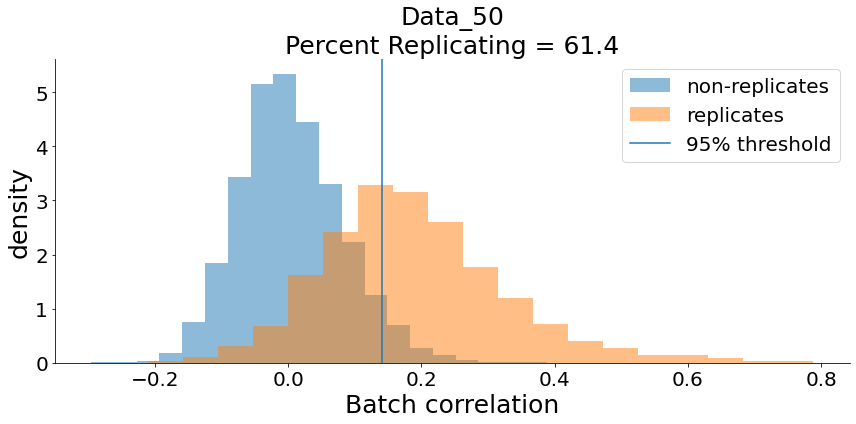

In [171]:
n_experiments = len(corr_random_replicating)

plt.rcParams['figure.facecolor'] = 'white' # Enabling this makes the figure axes and labels visible in PyCharm Dracula theme
plt.figure(figsize=[12, n_experiments*6])

for i in range(n_experiments):
    plt.subplot(n_experiments, 1, i+1)
    plt.hist(corr_random_replicating.loc[i,'Null_Replicating'], label='non-replicates', density=True, bins=20, alpha=0.5)
    plt.hist(corr_random_replicating.loc[i,'Replicating'], label='replicates', density=True, bins=20, alpha=0.5)
    plt.axvline(corr_random_replicating.loc[i,'Value_95'], label='95% threshold')
    plt.legend(fontsize=20)
    plt.title(
        f"{corr_random_replicating.loc[i,'Description']}\n" +
        f"Percent Replicating = {corr_random_replicating.loc[i,'Percent_Replicating']}",
        fontsize=25
    )
    plt.ylabel("density", fontsize=25)
    plt.xlabel("Batch correlation", fontsize=25)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    sns.despine()
plt.tight_layout()

plt.savefig(output_path + str(date.today()) + "_Percent_Replicating.pdf", 
            transparent=False, 
            bbox_inches='tight', 
            dpi = 600)

In [172]:
## gets feature vector
Features = CBE.get_feature_vector(Data_aggregated_filtered_copy)

random_median = pycytominer.consensus(
        profiles = Data_aggregated_filtered_copy, # A file or pandas DataFrame of profile data
        replicate_columns = ["Metadata_RoughID_randomized"], # Metadata columns indicating which replicates to collapse, defaults to [“Metadata_Plate”, “Metadata_Well”]
        operation = "median", # (str) – The method used to form consensus profiles, defaults to “median”
        features = Features, # (str, list) – The features to collapse, defaults to “infer”
)

In [174]:
key_col = ["Metadata_RoughID_randomized"]

active_random, low_active_random = CBE.remove_low_active(random_median, 
                                                   key_col,
                                                   2.0, 
                                                   5.0)

print("HepG2 active:", len(active_random["Metadata_RoughID_randomized"].unique()))
print("HepG2 low-active:", len(low_active_random["Metadata_RoughID_randomized"].unique()))

HepG2 active: 214
HepG2 low-active: 4397


In [175]:
active_random

,Metadata_RoughID_randomized,Nuc_AreaShape_BoundingBoxMaximum_X,Nuc_AreaShape_Eccentricity,Nuc_AreaShape_EquivalentDiameter,Nuc_AreaShape_Extent,Nuc_AreaShape_FormFactor,Nuc_AreaShape_MaxFeretDiameter,Nuc_AreaShape_MeanRadius,Nuc_AreaShape_MinorAxisLength,Nuc_AreaShape_Orientation,...,Cyto_Texture_InfoMeas2_DNA_3_00_256,Cyto_Texture_InfoMeas2_DNA_3_02_256,Cyto_Texture_InfoMeas2_DNA_5_00_256,Cyto_Texture_InfoMeas2_DNA_5_02_256,Cyto_Texture_InfoMeas2_DNA_5_03_256,Cyto_Texture_InfoMeas2_ER_3_02_256,Cyto_Texture_InverseDifferenceMoment_DNA_10_01_256,Cyto_Texture_InverseDifferenceMoment_DNA_10_03_256,Cyto_Texture_InverseDifferenceMoment_DNA_3_02_256,Cyto_Texture_InverseDifferenceMoment_ER_10_03_256
1,C1230_A02,0.038179,0.004129,-1.314710,-0.437068,-0.359069,-1.399080,-1.497480,-1.123004,-0.630601,...,-4.709328,-3.762852,-4.329547,-4.133711,-3.186518,0.570327,2.739436,3.232533,2.864511,-0.503307
159,C1230_G16,-0.411827,-1.413484,0.063933,1.047784,1.182069,-0.097705,0.576476,0.142647,-0.300965,...,1.268223,0.340958,1.233057,0.403992,0.897975,1.370029,0.098485,-0.606271,-0.683351,-0.810739
183,C1230_H16,-0.484922,-1.178897,0.684312,1.461440,1.078893,-0.112493,0.722542,0.283560,-0.259334,...,-0.705498,-0.679109,0.580334,0.417944,0.177580,0.407053,0.099040,-0.427529,0.369151,0.080820
194,C1230_I03,-0.596062,-0.929341,-1.164838,0.276748,-0.191212,-1.353408,-1.824050,-0.960624,0.627160,...,-1.551407,-1.755400,-1.769680,-2.146058,-1.254435,1.329276,0.392478,0.512107,1.835218,-0.930012
603,C1231_J04,-0.675971,-1.834964,-0.019382,1.256305,1.404472,-0.007887,0.002728,-0.499908,-0.220382,...,-1.705230,-1.727566,-2.434882,-1.531126,-1.691295,-0.550575,2.518940,2.535333,2.534901,1.147059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4462,C1272_J23,-0.138866,-0.436632,0.389797,-0.198259,-0.265278,0.156242,0.324233,-0.139322,-0.184222,...,-2.693616,-1.934031,-2.610604,-2.272825,-2.492186,-1.444833,2.768711,1.956378,1.606476,2.361787
4557,C1272_N22,0.361400,-0.834109,0.683568,0.353211,0.070595,0.000000,0.974586,1.067803,-0.738101,...,-2.322952,-1.765008,-1.906909,-2.453734,-1.538358,-3.112240,1.789865,1.987404,1.389499,3.721012
4584,C1272_P01,1.757240,0.152443,-4.602844,2.112430,3.070242,-2.604795,-4.206707,-4.829184,-0.828108,...,1.007936,1.319393,0.641793,0.865292,0.742549,2.289543,-2.083631,-1.459845,-1.556898,-0.957614
4609,Nocodazole,-0.089433,-12.377789,8.656394,7.668397,7.111386,3.750470,13.270054,10.517851,-0.047146,...,-5.095473,-4.443493,-4.678454,-4.081590,-3.275850,-8.302481,4.873573,4.892888,2.676434,2.565085


In [177]:
replicates_active_random = Data_aggregated_filtered_copy[
    (Data_aggregated_filtered_copy['Metadata_RoughID_randomized'].isin(active_random['Metadata_RoughID_randomized']))]

In [178]:
replicates_active_random.head()

,Metadata_imaging_date,Metadata_instrument,Metadata_Plate,Metadata_Well_randomized,Metadata_source,Metadata_RoughID,Metadata_Batch,Metadata_Object_Count,Metadata_staining_date,Metadata_user,...,Cyto_Texture_InfoMeas2_DNA_5_00_256,Cyto_Texture_InfoMeas2_DNA_5_02_256,Cyto_Texture_InfoMeas2_DNA_5_03_256,Cyto_Texture_InfoMeas2_ER_3_02_256,Cyto_Texture_InverseDifferenceMoment_DNA_10_01_256,Cyto_Texture_InverseDifferenceMoment_DNA_10_03_256,Cyto_Texture_InverseDifferenceMoment_DNA_3_02_256,Cyto_Texture_InverseDifferenceMoment_ER_10_03_256,Metadata_RoughID_unique,Metadata_RoughID_randomized
206,2024-06-05,CV8000,C1231R1,I15,IMTM,Nocodazole,HepG2_10uM,424,240531,Alzbeta,...,-0.623143,-0.928325,0.164249,-6.003206,2.318344,2.653950,0.157176,2.039780,Nocodazole,Nocodazole
219,2024-06-05,CV8000,C1231R1,J04,IMTM,Nocodazole,HepG2_10uM,479,240531,Alzbeta,...,-3.634962,-2.512027,-0.752192,-5.341595,2.860918,2.956333,2.875976,2.624228,Nocodazole,Nocodazole
224,2024-06-05,CV8000,C1231R1,J09,IMTM,EOS_cpd,HepG2_10uM,668,240531,Alzbeta,...,0.243049,0.512663,0.345882,0.968985,-0.517779,-0.933147,0.448056,-1.269869,C1231_G22,C1231_J09
260,2024-06-05,CV8000,C1231R1,K21,IMTM,Tetrandrine,HepG2_10uM,751,240531,Alzbeta,...,-2.256527,-0.357849,-0.838697,0.121001,0.170657,0.519479,0.205107,-0.209207,Tetrandrine,Tetrandrine
320,2024-06-05,CV8000,C1231R1,N09,IMTM,Tetrandrine,HepG2_10uM,756,240531,Alzbeta,...,0.152724,-0.433952,-0.424843,0.260149,-0.558427,-0.153483,0.133684,-0.669666,Tetrandrine,Tetrandrine


In [182]:
len(replicates_active_random["Metadata_RoughID_randomized"])

887

In [179]:
len(replicates_active_random["Metadata_RoughID_randomized"].unique())

214

In [183]:
HepG2_active_replicating_random, HepG2_active_corr_replicating_df_random = CBE.remove_non_reproducible(
    replicates_active_random, 
    n_samples = 10000, 
    n_replicates = 4, 
    ID_col = "Metadata_RoughID_randomized", 
    description = "Data_50")

| Description   |   Percent_Replicating |
|:--------------|----------------------:|
| Data_50       |                  54.2 |
Nonreplicating conditions removed with threshold 0.47
Old shape (887, 705)
New shape (587, 705)


/home/schmiedc/FMP_Docs/Projects/ECBL_Project/QualityControl_analysis_revision/notebooks_revision/CBE_utils.py:391: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  corr_replicating_df = corr_replicating_df.append({'Description': description,


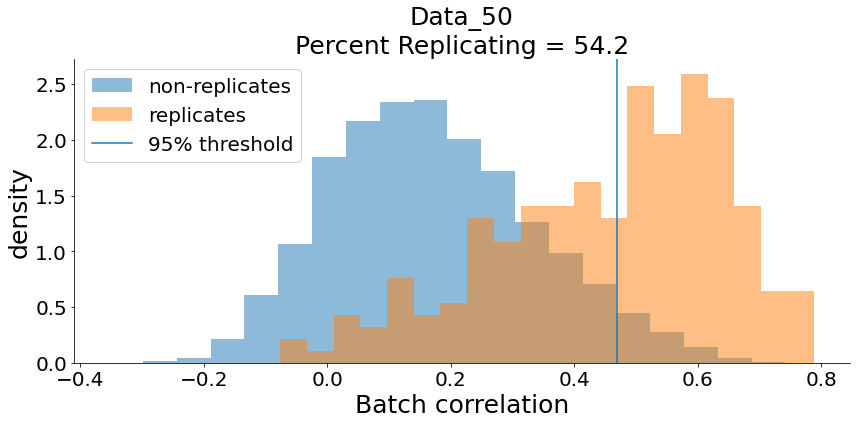

In [184]:
# plot % replicating
corr_replicating_df = HepG2_active_corr_replicating_df_random

n_experiments = len(corr_replicating_df)


plt.rcParams['figure.facecolor'] = 'white' # Enabling this makes the figure axes and labels visible in PyCharm Dracula theme
plt.figure(figsize=[12, n_experiments*6])

for i in range(n_experiments):
    plt.subplot(n_experiments, 1, i+1)
    plt.hist(corr_replicating_df.loc[i,'Null_Replicating'], label='non-replicates', density=True, bins=20, alpha=0.5)
    plt.hist(corr_replicating_df.loc[i,'Replicating'], label='replicates', density=True, bins=20, alpha=0.5)
    plt.axvline(corr_replicating_df.loc[i,'Value_95'], label='95% threshold')
    plt.legend(fontsize=20)
    plt.title(
        f"{corr_replicating_df.loc[i,'Description']}\n" +
        f"Percent Replicating = {corr_replicating_df.loc[i,'Percent_Replicating']}",
        fontsize=25
    )
    plt.ylabel("density", fontsize=25)
    plt.xlabel("Batch correlation", fontsize=25)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    sns.despine()
plt.tight_layout()

plt.savefig(output_path + str(date.today()) + "_Percent_Replicating_Induction_Filter.pdf", 
            transparent=False, 
            bbox_inches='tight', 
            dpi = 600)# 